In [1]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [2]:
from vfield import *

vfield = torch.load('data/vectorfield.pt')

grid = vfield['grid']
displacement=vfield['displacement']

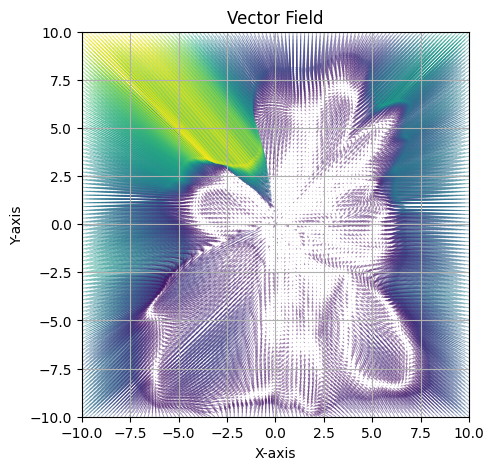

In [3]:
# matplotlib (currently in the NeurIPS submission)
plot_vector_field(grid, displacement)

generate lics: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


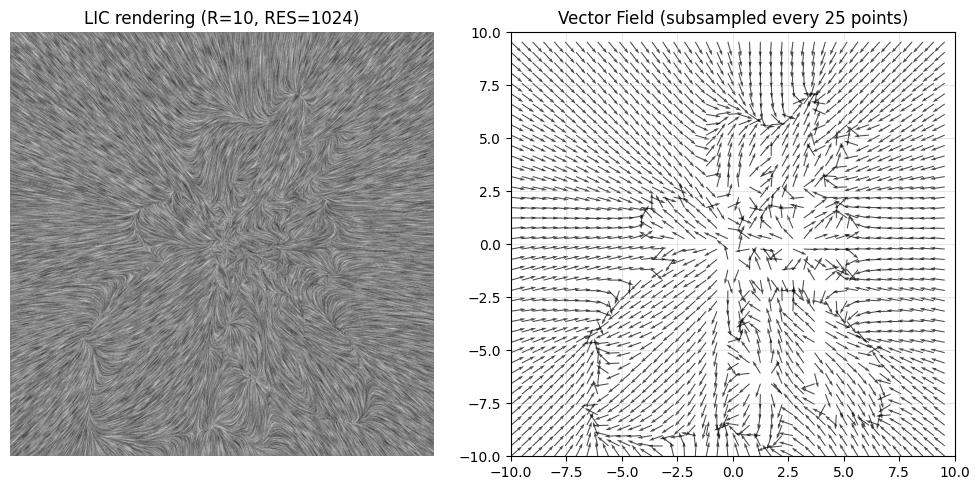

In [4]:
# render using LIC
lic_img_loaded = render_lic(grid, displacement, R=10, RES=1024, length=30, normalize=True)

In [5]:
import numpy as np
from PIL import Image, ImageDraw

# ------------- parameters -------------
W, H      = 4000, 4000          # canvas size
N_PART    = 10_000             # more particles = denser texture
STEPS     = 400                 # integration steps per particle
STEP_SIZE = 0.002               # ~ fraction of image width
ALPHA     = 2                   # 0-255 per stroke
BG        = 255                 # white background

# ------------- vector field -----------
def F(px, py):
    """Example: curl of Perlin-ish noise field (here a simple swirl)"""
    # map pixel → [-1,1] coords
    x = (px/W)*2 - 1
    y = (py/H)*2 - 1
    return -y, x      # simple vortex

# ------------- integrate --------------
img = Image.new("L", (W, H), BG)
drw = ImageDraw.Draw(img, "L")

rng = np.random.default_rng(0)
starts_x = rng.uniform(0, W,  N_PART)
starts_y = rng.uniform(0, H,  N_PART)

for x0, y0 in zip(starts_x, starts_y):
    x, y = x0, y0
    pts   = []
    for _ in range(STEPS):
        u, v = F(x, y)
        norm = (u*u + v*v)**0.5 + 1e-6
        x   += (u / norm) * STEP_SIZE * W
        y   += (v / norm) * STEP_SIZE * W
        if not (0 <= x < W and 0 <= y < H):
            break
        pts.append((x, y))
    if len(pts) > 1:
        drw.line(pts, fill=BG-ALPHA, width=1)   # low-alpha, additive

# img = img.filter(Image.BLUR)  # subtle blur like the example
img.save("flow_field.png")

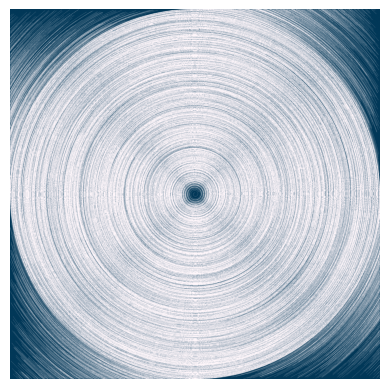

In [6]:
plt.imshow(img, cmap='PuBu', origin='lower')
plt.axis('off')
plt.show()